# Финальный проект: вариант 2

### студент: Панина Ольга
#### почта: olya.panina2001@yandex.ru

## Задание 1. A/B–тестирование
### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import bootstrap
import seaborn as sns
%matplotlib inline

import pandahouse as ph

### Загрузка файлов при помощи API

In [2]:
import requests
from urllib.parse import urlencode

#### Получаем groups.csv
- файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

In [3]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'  # Ссылка на файл на Я.Диске

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаем файл и сохраняем его
download_response = requests.get(download_url)

with open('groups.csv', 'wb') as f:  
    f.write(download_response.content)

In [4]:
groups = pd.read_csv('groups.csv', sep=';')

#### Получаем groups_add.csv 
- дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

In [5]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'  

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

download_response = requests.get(download_url)

with open('groups_add.csv', 'wb') as f:   
    f.write(download_response.content)

In [6]:
groups_add = pd.read_csv('groups_add.csv')

#### Получаем active_studs.csv 
- файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

In [7]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'  

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

download_response = requests.get(download_url)

with open('active_studs.csv', 'wb') as f:   
    f.write(download_response.content)

In [8]:
active_studs = pd.read_csv('active_studs.csv')

#### Получаем checks.csv 
- файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [9]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA' 

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

download_response = requests.get(download_url)

with open('checks.csv', 'wb') as f:  
    f.write(download_response.content)

In [10]:
checks = pd.read_csv('checks.csv', sep=';')

## Разведочный анализ данных

**Размер**

In [11]:
groups.shape

(74484, 2)

In [12]:
groups_add.shape

(92, 2)

In [13]:
active_studs.shape

(8341, 1)

In [14]:
checks.shape

(541, 2)

**Пропуски**

In [15]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [16]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [17]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [18]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

**Дубликаты**

In [19]:
groups.duplicated().sum()

0

In [20]:
groups.duplicated(subset=['id']).sum()

0

In [21]:
groups_add.duplicated().sum()

0

In [22]:
groups_add.duplicated(subset=['id']).sum()

0

In [23]:
active_studs.duplicated().sum()

0

In [24]:
checks.duplicated().sum()

0

In [25]:
checks.duplicated(subset=['student_id']).sum()

0

**Типы данных**

In [26]:
groups.dtypes

id      int64
grp    object
dtype: object

In [27]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [28]:
active_studs.dtypes

student_id    int64
dtype: object

In [29]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

Есть ли совпадения по id в таблицах groups и groups_add? Проверим через **inner join**

In [30]:
groups.merge(groups_add, on='id')

,id,grp_x,grp_y


Соединенная таблица содержит 0 записей. Делаю вывод, что id студентов не дублируются в этих двух таблицах. 
Соответственно, можем соединить таблицы при помощи **pd.concat**

In [31]:
frames = [groups, groups_add]

groups_all = pd.concat(frames)

In [32]:
groups_all

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


Посмотрим на размер тестовой и контрольной группы. Помним, что  А – контроль, B – экспериментальная группа.

In [33]:
groups_all.grp.value_counts()

B    59883
A    14693
Name: grp, dtype: int64

Соединим **groups_all и active_studs**, чтобы узнать группу пользователей, которые зашли на платформу в дни проведения эксперимента.

In [34]:
active_studs = active_studs.rename(columns={'student_id':'id'})

In [35]:
active_studs_groups = active_studs.merge(groups_all, how='left', on='id')

In [36]:
checks = checks.rename(columns={'student_id':'id'})

Теперь соединим **checks и active_studs_groups**

In [37]:
full_checks = checks.merge(active_studs_groups, how='left', on='id')

In [38]:
full_checks

,id,rev,grp
0,1627,990.0,A
1,3185,690.0,NaN
2,25973,690.0,NaN
3,26280,690.0,NaN
4,100300,990.0,B
...,...,...,...
536,5645737,1900.0,B
537,5651566,1900.0,B
538,5662322,1900.0,B
539,5681918,1900.0,B


Выясним, откуда значения NaN появились в таблице **full_checks**.

In [39]:
full_chechks_na = full_checks[full_checks.grp.isnull()]

In [40]:
full_chechks_na

,id,rev,grp
1,3185,690.0,NaN
2,25973,690.0,NaN
3,26280,690.0,NaN
5,100645,630.0,NaN
6,102534,580.0,NaN
...,...,...,...
508,5291900,199.0,NaN
512,5331842,290.0,NaN
521,5486319,199.0,NaN
530,5562806,398.0,NaN


In [41]:
active_studs_groups.query('id == 3185')

,id,grp


In [42]:
active_studs_groups.merge(full_chechks_na, on='id')

,id,grp_x,rev,grp_y


Получается, есть часть пользователей, которые совершили покупку в дни проведения эксперимента, но они не были в таблице пользователей, которые зашли на платформу в дни проведения эксперимента **(active_studs)**.

In [43]:
groups_all.merge(full_chechks_na, on='id')

,id,grp_x,rev,grp_y
0,3185,B,690.0,NaN
1,25973,B,690.0,NaN
2,26280,B,690.0,NaN
3,100645,B,630.0,NaN
4,102534,B,580.0,NaN
...,...,...,...,...
144,5291900,B,199.0,NaN
145,5331842,B,290.0,NaN
146,5486319,B,199.0,NaN
147,5562806,B,398.0,NaN


In [44]:
groups.merge(full_chechks_na, on='id')

,id,grp_x,rev,grp_y
0,3185,B,690.0,NaN
1,25973,B,690.0,NaN
2,26280,B,690.0,NaN
3,100645,B,630.0,NaN
4,102534,B,580.0,NaN
...,...,...,...,...
144,5291900,B,199.0,NaN
145,5331842,B,290.0,NaN
146,5486319,B,199.0,NaN
147,5562806,B,398.0,NaN


In [45]:
groups_add.merge(full_chechks_na, on='id')

,id,grp_x,rev,grp_y


Все эти пользователи есть в первой таблице groups, а не в groups_add, соответственно эта особенность не связана с тем, что данные дослали 2 дня спустя. Причина в чем-то другом. 
<br>
Могу предположить 2 варианта: 
- можно произвести оплату, не заходя на платформу (например, автоматический платеж)
- это ошибка системы сбора информации, которая не отобразила этих пользователей в таблице active_studs.

Я не буду включать данных юзеров в эксперимент, так как не ясно, были ли эти пользователи на платформе в дни эксперимента или нет (был бы это рабочий кейс, то обратилась бы к коллегам за дополнительной информацией).

In [46]:
full_checks_without_nan = full_checks.dropna()

In [47]:
full_checks_without_nan

,id,rev,grp
0,1627,990.0000,A
4,100300,990.0000,B
8,108270,290.0000,B
26,264473,1900.0001,B
27,274352,690.0000,B
...,...,...,...
536,5645737,1900.0000,B
537,5651566,1900.0000,B
538,5662322,1900.0000,B
539,5681918,1900.0000,B


In [48]:
full_checks_without_nan.grp.value_counts()

B    314
A     78
Name: grp, dtype: int64

## Метрики
Так как в эксперименте сравнивается новая механика оплаты услуг на сайте со старой, то мы имеем дело непосредственно с показателями доходов.
<br><br>
Имеющиеся данные дают нам возможность посмотреть на изменения следующих метрик:
- **Конверсия в покупку** (CR, Conversion Rate) - отношение числа пользователей, которые совершили покупку к общему числу посетителей.
- **Средний чек покупки** = Доход / Кол-во покупок
- **Средний доход с привлеченного пользователя** (ARPU)
- **Средний доход с платящего клиента** (ARPPU)

### 1. Конверсия в покупку 

 В данном случае конверсию буду рассчитывать как 
 $$
CR = \frac {количество\:юзеров, совершивших\:покупку} {количество\:активных\:юзеров}
$$ 

Числитель - это наша таблица checks. Присвоим ей колонку "payed" со значением 1, чтобы в дальнейшем отслеживать статус оплаты у юзера.

In [49]:
checks['payed'] = 1

In [50]:
checks.head()

,id,rev,payed
0,1627,990.0,1
1,3185,690.0,1
2,25973,690.0,1
3,26280,690.0,1
4,100300,990.0,1


Соединим checks и groups_all, чтобы знать принадлежность к группе.

In [51]:
checks_upd = checks.merge(groups_all, on='id')

In [52]:
checks_upd.head()

,id,rev,payed,grp
0,1627,990.0,1,A
1,3185,690.0,1,B
2,25973,690.0,1,B
3,26280,690.0,1,B
4,100300,990.0,1,B


Знаменатель - таблица active_studs_groups. Аналогично, добавим колонку "active", говорящую о статусе активности на платформе в дни эксперимента.

In [53]:
active_studs_groups['active'] = 1

In [54]:
active_studs_groups.head()

,id,grp,active
0,581585,A,1
1,5723133,A,1
2,3276743,B,1
3,4238589,A,1
4,4475369,B,1


Теперь склеим эти таблицы с groups_all, чтобы получить сводный датафрейм со статусами оплаты и активности.

In [55]:
groups_active = groups_all.merge(active_studs_groups, how='left', on=['id', 'grp'])

In [56]:
df_status = groups_active.merge(checks_upd, how='left', on=['id', 'grp'])

In [57]:
df_status.head()

,id,grp,active,rev,payed
0,1489,B,NaN,NaN,NaN
1,1627,A,1.0,990.0,1.0
2,1768,B,NaN,NaN,NaN
3,1783,B,NaN,NaN,NaN
4,1794,A,NaN,NaN,NaN


Чтобы корректно заполнить NaN, посмотрим сначала на имеющиеся номиналы покупок, чтобы исключить возможность покупок на сумму "0 рублей" или "1 рубль".

In [58]:
df_status.rev.value_counts()

1900.0000    97
290.0000     94
690.0000     78
199.0000     46
990.0000     41
1900.0001    36
840.0000     27
1140.0000    25
580.0000     15
590.0000     11
398.0000      9
1530.0000     8
870.0000      6
3660.0000     5
2910.0000     4
1980.0000     4
2890.0000     4
489.0000      3
1160.0000     3
2099.0000     3
2220.0000     2
1180.0000     2
2820.0000     2
1339.0000     1
1388.0000     1
1830.0000     1
1050.0000     1
2190.0000     1
4650.0000     1
3260.0000     1
3040.0000     1
2900.0000     1
1968.0000     1
796.0000      1
1729.0000     1
880.0000      1
630.0000      1
597.0000      1
1039.0000     1
Name: rev, dtype: int64

Покупок на сумму "0 рублей" не наблюдается, значит можно заполнить NaN нулями.

In [59]:
df_status.fillna(0, inplace=True)

In [60]:
df_status.head()

,id,grp,active,rev,payed
0,1489,B,0.0,0.0,0.0
1,1627,A,1.0,990.0,1.0
2,1768,B,0.0,0.0,0.0
3,1783,B,0.0,0.0,0.0
4,1794,A,0.0,0.0,0.0


In [61]:
df_status = df_status.astype({'active' : 'int', 'payed' : 'int'})

In [62]:
df_status.head()

,id,grp,active,rev,payed
0,1489,B,0,0.0,0
1,1627,A,1,990.0,1
2,1768,B,0,0.0,0
3,1783,B,0,0.0,0
4,1794,A,0,0.0,0


Отберем активных юзеров, имеющих покупки. Таким способом, у нас отсеятся те неактивные юзеры, совершившие покупку.

In [63]:
total = df_status.query('active == 1').groupby('grp').agg({'active':'count', 'payed':'sum', 'rev':'sum'})

In [64]:
total

,active,payed,rev
grp,,,
A,1538,78,72820.0000
B,6803,314,394974.0035


In [65]:
total['CR_%'] = (total.payed / total.active).mul(100)

In [66]:
total

,active,payed,rev,CR_%
grp,,,,
A,1538,78,72820.0000,5.071521
B,6803,314,394974.0035,4.615611


**Конверсия** в целевой группе (В) меньше на ~0.46, чем в группе А.

### 2. Средний чек покупки
$$
AvCheck = \frac {Доход} {Кол-во\:покупок}
$$

In [67]:
total['AvCheck'] = total.rev/total.payed

In [68]:
total

,active,payed,rev,CR_%,AvCheck
grp,,,,,
A,1538,78,72820.0000,5.071521,933.589744
B,6803,314,394974.0035,4.615611,1257.878992


**Средний чек** в целевой группе (В) больше на ~324 ден.ед., чем в группе А.

### 3. Средний доход с привлеченного пользователя (ARPU)
$$
ARPU = \frac {Доход} {Количество\:пользователей}
$$

In [69]:
total['ARPU'] = total.rev/total.active

In [70]:
total

,active,payed,rev,CR_%,AvCheck,ARPU
grp,,,,,,
A,1538,78,72820.0000,5.071521,933.589744,47.347204
B,6803,314,394974.0035,4.615611,1257.878992,58.058798


**ARPU** в целевой группе (В) больше на ~11 ден.ед., чем в группе А.

Таким образом, конверсия у нас лучше при старой оплате услуг, а средний чек и средний доход на привлеченного пользователя выше у тех, кто имел доступ к новой механике оплаты. Картина неоднозначная, приступим к проверке статистической значимости.

### Конверсия в покупку: проверка стат. значимости
Применим критерий Хи-квадрата, т.к. данные о конверсии являются категориальными.
- $H_0$: между группами А и В нет существенного различия в конверсии
- $H_1$: существенные различия есть

In [71]:
df_cr = df_status.query('active == 1').groupby(['grp', 'payed'], as_index=False).agg({'id':'count'})

In [72]:
df_cr

,grp,payed,id
0,A,0,1460
1,A,1,78
2,B,0,6489
3,B,1,314


In [73]:
df_cr.pivot(index='grp', columns='payed', values='id')

payed,0,1
grp,,
A,1460,78
B,6489,314


In [74]:
from scipy.stats import chi2_contingency, chi2

stat, p, dof, expected = chi2_contingency(df_cr.pivot(index='grp', columns='payed', values='id'))

In [75]:
p

0.48625240457231045

**P_value** значительно превышает 0.05, исходя из этого мы не можем отвергнуть нулевую гипотезу, конверсия не изменилась существенно.

### Средний чек: проверка стат. значимости

- $H_0$: между группами А и В нет существенного различия в размере среднего чека
- $H_1$: существенные различия есть

Разделим данные о сумме покупок в зависимости от группы А/В.

In [76]:
a_check = df_status.query('active == 1 & payed == 1 & grp == "A"')[['grp', 'rev']]

In [77]:
a_check.head()

,grp,rev
1,A,990.0
4625,A,1830.0
6328,A,2910.0
7071,A,2820.0
9916,A,3660.0


In [78]:
b_check = df_status.query('active == 1 & payed == 1 & grp == "B"')[['grp', 'rev']]

In [79]:
b_check.head()

,grp,rev
220,B,990.0000
320,B,290.0000
3779,B,1900.0001
4187,B,690.0000
4399,B,199.0000


Посмотрим как распределены значения покупок на графиках.

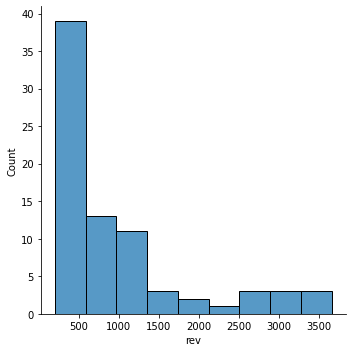

In [80]:
# A группа
sns.displot(a_check.rev)

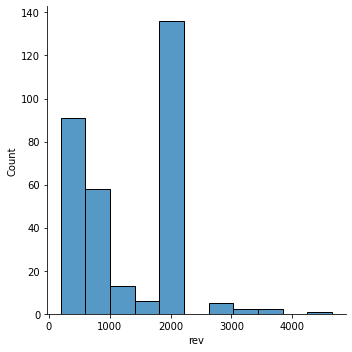

In [81]:
# В группа
sns.displot(b_check.rev)

Проверим требование на гомогенность дисперсий с помощью критерия Левена. Нулевая гипотеза - дисперсии равны, альтернативная гипотеза - дисперсии не равны.

In [82]:
stats.levene(a_check.rev, b_check.rev)

LeveneResult(statistic=3.075681699981606, pvalue=0.08025675761347022)

P-значение теста Левена немногим больше 0.05, нулевая гипотеза равных дисперсий не отвергается и разницы между дисперсиями нет.

Применим T-критерий Стьдента для оценки выборочных средних по суммам заказов.<br><br>

In [83]:
stats.ttest_ind(a_check.rev, b_check.rev)

Ttest_indResult(statistic=-3.1337795050930985, pvalue=0.0018562025265765867)

Так как **pvalue=0.0019**, это меньше 0.05, у нас есть основания отклонить нулевую гипотезу. Соответственно, делаем вывод, что средняя сумма заказа в контрольной и тестовой группах различаются статистически значимо. 

### ARPU: проверка стат. значимости

- $H_0$: между группами А и В нет существенного различия в размере среднего дохода на привлеченного пользователя
- $H_1$: существенные различия есть

Также разделим наши данные в зависимости от группы.

In [84]:
a_arpu = df_status.query('active == 1 & grp == "A"')[['grp', 'rev']]

In [85]:
a_arpu.head()

,grp,rev
1,A,990.0
43,A,0.0
331,A,0.0
614,A,0.0
1002,A,0.0


In [86]:
b_arpu = df_status.query('active == 1 & grp == "B"')[['grp', 'rev']]

In [87]:
b_arpu.head()

,grp,rev
10,B,0.0
12,B,0.0
45,B,0.0
112,B,0.0
159,B,0.0


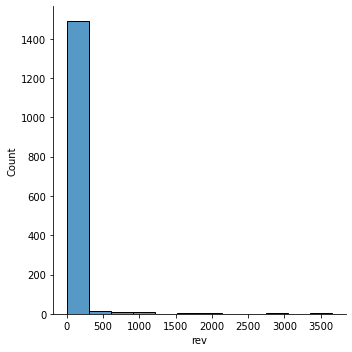

In [88]:
sns.displot(a_arpu.rev)

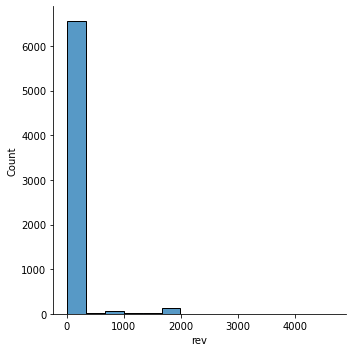

In [89]:
sns.displot(b_arpu.rev)

Проверим требование на гомогенность дисперсий с помощью критерия Левена. Нулевая гипотеза - дисперсии равны, альтернативная гипотеза - дисперсии не равны.

In [90]:
stats.levene(a_arpu.rev, b_arpu.rev)

LeveneResult(statistic=1.501460829433639, pvalue=0.22048133327049665)

Pvalue=0.22 и больше 0.05, дисперсии гомогенны, значит мы можем применить Т-тест.

In [91]:
stats.ttest_ind(a_arpu.rev, b_arpu.rev)

Ttest_indResult(statistic=-1.2253411073793445, pvalue=0.22048133326988378)

Pvalue > 0.05, нет статистически значимых различий между ARPU в тестовой и контрольной группах.

## Вердикт по внедрению новой механики оплаты услуг

Вернемся к общим результатам и соотнесем их со статистическими выводами.

In [92]:
total

,active,payed,rev,CR_%,AvCheck,ARPU
grp,,,,,,
A,1538,78,72820.0000,5.071521,933.589744,47.347204
B,6803,314,394974.0035,4.615611,1257.878992,58.058798


In [93]:
groups_all.grp.value_counts(normalize=True)

B    0.80298
A    0.19702
Name: grp, dtype: float64

1. CR в контрольной группе выше на 0.46 п.п., однако критерий Хи-квадрата показал, что изменения не являются статистически значимыми.
2. Средний чек в целевой группе выше на 324 д.ед., и тест Т-стьюдента потвердил стат. значимые различия в данных.
3. ARPU выше в целевой группе на 11 д.ед., однако статистически это не значимо.

По моему мнению, показатель среднего чека важнее ARPU, по крайней мере, в нашем случае, так как среди активных юзеров только 4-5% из них - платящие.

Я бы склонилась к тому, чтобы раскатить новую механику на всех пользователей, однако при этом заранее уточнила бы, почему часть покупок была сделана клиентами, не являющимися активными на платформе + сформировала бы группы изначально в более равной пропорции (группа В составляет только ~5-ю часть от всей выборки).

## Задание 2. SQL
### 2.1 Очень усердные ученики.

#### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

In [94]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

Посмотрим на данные

In [95]:
query = """
select st_id, timest, correct, subject
from default.peas
limit 10
"""
peas = ph.read_clickhouse(query, connection=connection)
peas

KeyError: 'DateTime64(3)'

In [ ]:
query = """
select toTypeName(timest)
from default.peas
limit 1
"""
peas = ph.read_clickhouse(query, connection=connection)
peas

Т.к. колонка timest имеет тип DateTime64(3), он не считывается пандасом, приведем к стандартному datetime.

In [ ]:
query = """
select 
        st_id, 
        toDateTime(timest) as timest, 
        correct, 
        subject
from default.peas
limit 10
"""
peas = ph.read_clickhouse(query, connection=connection)
peas

#### 2.1.2 Задача
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

Формулировка задачи наталкивает на следующие вопросы:
- за какой период времени у нас есть данные?
- считается ли ученик усердным если он решил ровно 20 задач или более 20? 

Посмотрим минимальную и максимальную дату.

In [ ]:
query = """
select 
        toDateTime(min(timest)) as min_date, 
        toDateTime(max(timest)) as max_date
from default.peas
"""
peas = ph.read_clickhouse(query, connection=connection)
peas

Имеются данные чуть более за сутки, с 30 окт. по 31 окт. 2020 года, т.е. эти данные принадлежат к одному месяцу, дополнительно не нужно фильтроваться.

Посмотрим на количество уникальных студентов.

In [ ]:
query = """
select uniqExact(st_id)
from default.peas
"""
peas = ph.read_clickhouse(query, connection=connection)
peas

Сгруппируемся по id и выведем студентов, кто решил более 19 горошин.

In [ ]:
query = """
select 
        st_id, 
        sum(correct) as solved
from default.peas
group by st_id
having sum(correct) > 19
order by solved DESC
"""
peas = ph.read_clickhouse(query, connection=connection)
peas

Так как нужно вывести информацию только о количестве усердных учеников, сделаем подзапрос. В теле where отберем только те строки, которые нужны для вычислений.

In [ ]:
query = """

select uniqExact(st_id) as diligent_students_quantity
from
    (
    select 
            st_id, 
            sum(correct) as solved
    from default.peas
    where correct != 0
    group by st_id
    having sum(correct) > 19
    )
"""
peas = ph.read_clickhouse(query, connection=connection)
peas

### 2.2 Оптимизация воронки

#### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU (Average Revenue Per Active User)  
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике. <br><br>

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

Таблицы:
- default.peas
- default.studs
- default.final_project_check

Кол-во уникальных студентов в таблицах:
- peas : 308
- studs : 600
- final_project_check : 47

In [96]:
query = """

select *
from default.studs
    
"""
t = ph.read_clickhouse(query, connection=connection)
t

,st_id,test_grp
0,100379,pilot
1,101432,control
2,104818,pilot
3,104885,pilot
4,104966,pilot
...,...,...
595,988626,pilot
596,993249,pilot
597,994983,pilot
598,996911,control


Кол-во строк в studs совпадает с кол-вом уникальных студентов, дубликатов нет.

In [103]:
query = """

select 
        a.test_grp as test_grp,
        round(sum(money)/count(a.st_id), 2) as ARPU,
        round(sumIf(money, solved > 10)/countIf(money, solved > 10), 2) as ARPAU,
        round(countIf(a.st_id, money>0)*100/count(a.st_id), 2) as CR,
        round(countIf(a.st_id, money>0 and solved>10)*100/countIf(a.st_id, solved > 10), 2) as CR_active,
        round(countIf(a.st_id, math >= 2 and math_buy>0)*100/countIf(a.st_id, math >= 2), 2) as CR_math

from 
        default.studs as a
left join 
        (select 
                st_id, 
                sum(correct) as solved,
                sumIf(correct, subject=='Math') as math
        from default.peas
        group by st_id) as b
         
on 
        a.st_id=b.st_id
left join 
        (select 
                st_id, 
                sum(money) as money, 
                count(subject) as buys,
                countIf(st_id, subject='Math') as math_buy
        from default.final_project_check
        group by st_id) as c
on 
        a.st_id=c.st_id
group by a.test_grp
    
"""
t = ph.read_clickhouse(query, connection=connection)
t

,test_grp,ARPU,ARPAU,CR,CR_active,CR_math
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


## Задание 3. Python
### 3.1 Задача

- Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
- Реализуйте функцию, которая будет строить графики по получаемым метрикам.

p.s. насколько я поняла первую часть задания, функцию я напишу на основе 1-го задания проекта, только более сжато и без EDA

### Часть 1

In [104]:
groups = pd.read_csv('groups.csv', sep=';')

In [107]:
active_studs = pd.read_csv('active_studs.csv')
active_studs = active_studs.rename(columns={'student_id':'id'})

In [108]:
checks = pd.read_csv('checks.csv', sep=';')
checks = checks.rename(columns={'student_id':'id'})

In [120]:
def upd_total(groups, groups_add, active_studs, checks):
    
    groups_add = pd.read_csv('groups_add.csv')

#   объединим данные о группах и пользователях    
    frames = [groups, groups_add]
    groups_all = pd.concat(frames)
    
#   промаркируем строки единицами для статуса оплаты
    checks['payed'] = 1

#   промаркируем строки единицами для статуса активности    
    active_studs['active'] = 1
    
#   склеим эти таблицы с groups_all, чтобы получить сводный датафрейм со статусами оплаты и активности.
    df_status = groups_all.merge(active_studs, how='left', on='id')
    df_status = df_status.merge(checks, how='left', on='id')
    
#   заполним NaN и приведем к целочисленному типу
    df_status.fillna(0, inplace=True)
    df_status = df_status.astype({'active' : 'int', 'payed' : 'int'})
    
#   считаем метрики
    total = df_status.query('active == 1').groupby('grp').agg({'active':'count', 'payed':'sum', 'rev':'sum'})
    total['CR_%'] = ((total.payed / total.active).mul(100)).round(2)
    total['AvCheck'] = (total.rev/total.payed).round(2)
    total['ARPU'] = (total.rev/total.active).round(2)
    total.rev = total.rev.round(2)
    total.reset_index(inplace=True)
    
    return total

In [121]:
total = upd_total(groups, groups_add, active_studs, checks)

In [122]:
total

,grp,active,payed,rev,CR_%,AvCheck,ARPU
0,A,1538,78,72820.0,5.07,933.59,47.35
1,B,6803,314,394974.0,4.62,1257.88,58.06


### Часть 2

In [123]:
import plotly.express as px

In [146]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [144]:
def charts(total):
    
    fig = make_subplots(rows=1, cols=3, subplot_titles=("Конверсия в покупку, %", "Средний чек", "ARPU"))

    fig.add_trace(
        go.Bar(x=total.grp, y=total['CR_%']),
        row=1, col=1
    )

    fig.add_trace(
        go.Bar(x=total.grp, y=total.AvCheck),
        row=1, col=2
    )

    fig.add_trace(
        go.Bar(x=total.grp, y=total.ARPU),
        row=1, col=3
    )

    fig.update_layout(showlegend=False, height=600, width=1000, title_text="Метрики эксперимента")
    fig.show()
    
    return 

In [145]:
charts(total)